<a href="https://colab.research.google.com/github/USCbiostats/PM520/blob/main/Lab_6_ExpFam_Divergences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# It's a Family Affair, or: Exponential Families, Natural Gradient Descent, & Statistical Divergences

[Exponential Families](https://en.wikipedia.org/wiki/Exponential_family) (sometimes abbreviated as ExpFam) provide a [succinct characterization](https://en.wikipedia.org/wiki/Exponential_family#Table_of_distributions) of many distributions (e.g., [Normal](https://en.wikipedia.org/wiki/Normal_distribution), [Gamma](https://en.wikipedia.org/wiki/Gamma_distribution), [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution), [Wishart](https://en.wikipedia.org/wiki/Wishart_distribution), etc.). We'll take an informal look at their properties and how to perform inference.

We'll also take an informal review of [statistical divergences](https://en.wikipedia.org/wiki/Divergence_%28statistics%29), which reflect notions of a "distance" between parametric distributions.

Lastly, we look at another means to perform optimization, but different from previous approaches, we show how to generalize notions of "steepest" to consider the underlying geometry in a distributional sense through *natural* gradient descent.

## Exponential Families
Let $\eta = [\eta_1, \dotsc, \eta_k]$ be a $k$-vector of parameters, and $x$ be an observation such that $x \sim f(\eta)$. We can define its [PDF](https://en.wikipedia.org/wiki/Probability_density_function) (or [PMF](https://en.wikipedia.org/wiki/Probability_mass_function) in case of discrete $x$) as $$f(x | \eta) = h(x)\exp(\eta \cdot T(x) - A(\eta)),$$ where $h(x)$ is a *base measure*, $\eta$ are the *natural parameters*, $T(x)$ are the [*sufficient statistics*](https://en.wikipedia.org/wiki/Sufficient_statistic), and $A(\eta)$ is the [*log-partition function*](https://en.wikipedia.org/wiki/Partition_function_%28mathematics%29). If $\eta$ is *finite*, and the [*support*](https://en.wikipedia.org/wiki/Support_%28mathematics%29%23In_probability_and_measure_theory) of $f$ does not depend on the value of $\eta$, then $f$ can be said to be a member of the [Exponential Families](https://en.wikipedia.org/wiki/Exponential_family).

### Example: Normal Distribution
Recall if $x \sim N(\mu, \sigma^2)$, then the PDF of $x$ is given by,
$$f(x | \mu, \sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2 \sigma^2}\right).$$ To see that the two-parameter Normal distribution is a member of the Exponential Families, define $\eta = [\frac{\mu}{\sigma^2}, -\frac{1}{2\sigma^2}]$, $h(x) = \frac{1}{\sqrt{2\pi}}$, $T(x) = [x, x^2]^T$, and $A(\eta) = \frac{\mu^2}{2\sigma^2} + \log |\sigma| = -\frac{\eta_1^2}{4\eta_2} + \frac{1}{2}\log|\frac{1}{2\eta_2}|$. Placing this all together we have,
$$\begin{align*}
f(x | \eta) &= h(x)\exp(\eta \cdot T(x) - A(\eta)) \\
  &= \frac{1}{\sqrt{2\pi}} \exp(\eta \cdot T(x) - A(\eta)) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left([\frac{\mu}{\sigma^2}, -\frac{1}{2\sigma^2}] \cdot T(x) - A(\eta)\right) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left([\frac{\mu}{\sigma^2}, -\frac{1}{2\sigma^2}] \cdot [x, x^2]^T - A(\eta)\right) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left(\frac{\mu x}{\sigma^2} -\frac{x^2}{2\sigma^2} - A(\eta)\right) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left(\frac{\mu x}{\sigma^2} -\frac{x^2}{2\sigma^2} + \frac{\eta_1^2}{4\eta_2} - \frac{1}{2}\log\left|\frac{1}{2\eta_2}\right|\right) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left(\frac{\mu x}{\sigma^2} -\frac{x^2}{2\sigma^2} - \frac{\mu^2}{2\sigma^2} - \log |\sigma|\right) \\
  &= \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2} - \log |\sigma|\right) \\
  &= \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) \\
  &= \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right) \\
\end{align*}$$

## Expectations
A key property of ExpFam distributions is that one can define the [moments](https://en.wikipedia.org/wiki/Moment_%28mathematics%29) of $T(x)$ from the log-partition function $A(\eta)$. Two key moments to remember are, $\mathbb{E}[T(x)] = \frac{\partial}{\partial \eta} A(\eta)$ and $\mathbb{V}[T(x)] = \frac{\partial^2}{\partial \eta \partial \eta^T} A(\eta)$.

In the case of scalar Normal variables, we have $\mathbb{E}[T(x)] = \mathbb{E}\left[[x, x^2]\right] = [\mu, \sigma^2 + \mu^2]$ and $\mathbb{V}[T(x)] = \begin{bmatrix} \sigma^2 & 0 \\ 0 & 2\sigma^4 \end{bmatrix}$.
$$\begin{align*}
\mathbb{E}[T(x)] &= \frac{\partial}{\partial \eta} A(\eta) \\
  &= \frac{\partial}{\partial \eta} \left[-\frac{\eta_1^2}{4\eta_2} + \frac{1}{2}\log|\frac{1}{2\eta_2}|\right] \\
  &= -\frac{\partial}{\partial \eta} \frac{\eta_1^2}{4\eta_2} + \frac{\partial}{\partial \eta}\frac{1}{2}\log|\frac{1}{2\eta_2}| \\
  &= -\frac{\partial}{\partial \eta} \frac{\eta_1^2}{4\eta_2} - \frac{\partial}{\partial \eta}\frac{1}{2}\log|2\eta_2| \\
\mathbb{E}[T(x)]_1 &= -\frac{\partial}{\partial \eta_1} \frac{\eta_1^2}{4\eta_2} - \frac{\partial}{\partial \eta_1}\frac{1}{2}\log|2\eta_2| \\
  &= - \frac{2 \eta_1}{4 \eta_2} = -\frac{\eta_1}{2 \eta_2} = -\frac{\mu / \sigma^2}{-2 / (2\sigma^2)} = \mu \\
\mathbb{E}[T(x)]_2 &= -\frac{\partial}{\partial \eta_2} \frac{\eta_1^2}{4\eta_2} - \frac{\partial}{\partial \eta_2}\frac{1}{2}\log|2\eta_2| \\
  &= \frac{\eta^2_1}{\eta_2^2} - \frac{1}{2\eta_2} = \frac{\mu^2/\sigma^4}{1/\sigma^4} + \frac{1}{1 / \sigma^2} = \mu^2 + \sigma^2.
\end{align*}$$

## MLE Inference for ExpFam
Given $x_1, \dotsc, x_n$ we assume that $x_i \sim f(\eta)$ independently and identically distributed under some ExpFam dist $f$ with natural parameters $\eta$. Our log-likelihood is then given by,
$$ \ell(\eta) = \sum_{i=1}^n \log f(x_i | \eta).$$ To identify the
maximum likelihood estimates we first compute the gradient of $\ell$ wrt $\eta$, which is given by
$$\begin{align*}
\nabla \ell(\eta) &= \sum_{i=1}^n \nabla \log f(x_i | \eta) \\
  &= \sum_{i=1}^n \nabla \log \left[ h(x_i)\exp(\eta \cdot T(x_i) - A(\eta))\right] \\
  &= \sum_{i=1}^n \nabla \left[\log h(x_i) + \log \exp(\eta \cdot T(x_i) - A(\eta))\right] \\
  &= \sum_{i=1}^n \nabla \log h(x_i) + \nabla \log \exp(\eta \cdot T(x_i) - A(\eta)) \\
  &= \sum_{i=1}^n \nabla [\eta \cdot T(x_i)] - \nabla A(\eta) \\
  &= \sum_{i=1}^n T(x_i) - \mathbb{E}[T(x_i)],
\end{align*}$$
where we used the fact that  $\nabla A(\eta) = \mathbb{E}[T(x)]$. Setting this to zero and solving implies, we would like to find values $\eta$ such that $\sum_i T(x_i) = \sum_i \mathbb{E}[T(x_i)] = n \mathbb{E}[T(X)] ⇒ \frac{1}{n} \sum_i T(x_i) = \mathbb{E}[T(X)]$! In other words, MLE under ExpFam seeks values of $\eta$ that *match the empirical mean of the observed sufficient statistics to their expectation*!

## It's an Equinox for all seasons
TBD: Information on `equinox`, (functional) objective oriented programming, abstract base classes. More documentation on `Normal` class.

In [ ]:
!pip install equinox

In [2]:
from abc import abstractmethod

import equinox as eqx
import jax
import jax.numpy as jnp
from jaxtyping import Array, ArrayLike


class ExpFam(eqx.Module):
  """
  Simple base class for Exponential Families. Will keep track of
  observations as internal state and provide means to evaluate
  the loglikelihood of downstream implementations.

  x: Array, our observations
  """

  x: Array

  @abstractmethod
  def base_measure(self) -> Array:
    """
    Computes the base measure for an implementation of ExpFam.

    Returns:
      The base measure for an implementation of ExpFam.
    """
    ...

  @abstractmethod
  def sufficient_statistics(self) -> Array:
    """
    Computes the sufficient statistics (i.e. $T(x)$) for an implementation
    of ExpFam.

    Returns:
      The sufficient statistics for each observation under an implementation
      of ExpFam.
    """
    ...

  @abstractmethod
  def log_partition(self, eta: ArrayLike) -> Array:
    """
    Computes the log partition function (i.e. $A(\eta)$) for an implementation
    of ExpFam with natural parameters $\eta$.

    eta: ArrayLike, the natural parameters to evaluate under the log partition.

    Returns:
      The value of the log partition function for each observation under an
      implementation of ExpFam.
    """
    ...

  def loglikelihood(self, eta: ArrayLike) -> Array:
    """
    Computes the log likelihood for each observation $x$ under an implementation
    of ExpFam with natural parameters $\eta$.

    eta: ArrayLike, the natural parameters to evaluate under the log likelihood.

    Returns:
      The log likelihood for each observation under an implementation of ExpFam.
    """

    t_x = self.sufficient_statistics()
    log_h_x = jnp.log(self.base_measure())
    log_eta = self.log_partition(eta)
    return t_x @ eta - log_eta + log_h_x

  def __call__(self, eta: ArrayLike) -> Array:
    return self.loglikelihood(eta)


class Normal(ExpFam):

  def base_measure(self) -> Array:
    return 1. / jnp.sqrt(2 * jnp.pi)

  def sufficient_statistics(self) -> Array:
    x = self.x
    x_sq = self.x ** 2
    return jnp.concatenate((x[:, jnp.newaxis], x_sq[:, jnp.newaxis]), axis=1)

  def log_partition(self, eta: ArrayLike) -> Array:
    eta_1, eta_2 = eta
    term1 = -(eta_1**2 / (4 * eta_2))
    term2 = -0.5 * jnp.log(- 2 * eta_2)
    return term1 + term2

Great! Having implemented our objects to perform MLE in a general setting, with a specific example of normal distributions, let's perform some sanity checks before proceeding with inference.

In [3]:
import jax.random as rdm

# initialize our PRNG state
seed = 0
key = rdm.PRNGKey(seed)

# define some parameter values for N(mu, sigma2)
mu = 5.0
sigma_sq = 10.0

# generate random data
N = 10
key, x_key = rdm.split(key)
obs = mu + jnp.sqrt(sigma_sq) * rdm.normal(x_key, shape=(N,))

# transform parameters to natural parameters and create some other guess at eta
eta_true = jnp.array([mu / sigma_sq, - 1. / (2 * sigma_sq)])
eta_guess = jnp.array([-9, -100.])

# create an instance of Normal distribution using our implementation above
model = Normal(obs)

# calculate the sum of log likelihood
# equivalent to `jnp.sum(model.loglikelihood(eta_true))`
sum_ll_true = jnp.sum(model(eta_true))
sum_ll_guess = jnp.sum(model(eta_guess))
print(f"true logl $\ell$({eta_true}) = {sum_ll_true} | guess logl $\ell$({eta_guess}) = {sum_ll_guess}")

# sanity check against jax loglikelihood
import jax.scipy.stats as stats
jax_ll_true = jnp.sum(stats.norm.logpdf(obs, mu, jnp.sqrt(sigma_sq)))
print(f"Our $\ell$({eta_true}) = {sum_ll_true} | JAX logl $\ell$({eta_true}) = {jax_ll_true}")

true logl $\ell$([ 0.5  -0.05]) = -26.96800994873047 | guess logl $\ell$([  -9. -100.]) = -17816.912109375
Our $\ell$([ 0.5  -0.05]) = -26.96800994873047 | JAX logl $\ell$([ 0.5  -0.05]) = -26.9680118560791


## Statistical Divergences
[Divergences](https://en.wikipedia.org/wiki/Divergence_%28statistics%29) capture a notion of "[statistical distance](https://en.wikipedia.org/wiki/Statistical_distance)" between parameterized distribution functions. Their full definition is beyond the scope of this course, but key properties to recall are, given distributions $q$ and $p$ over the same [sample space](https://en.wikipedia.org/wiki/Sample_space), a divergence statisfies $D(p || q) \geq 0$ and $D(p || q) = 0$ iff $p = q$. There are many [different kinds](https://en.wikipedia.org/wiki/Divergence_%28statistics%29%23Examples) of divergences, but a very commonly used divergence is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), or KL divergence.

For discrete $x$ with sample space $\mathcal{X}$, we have,
$$
\begin{align*}
D_{KL}(p || q) &= \sum_{x \in \mathcal{X}} p(x) \log \frac{p(x)}{q(x)} = - \sum_{x \in \mathcal{X}} p(x) \log \frac{q(x)}{p(x)} \\
  &= -\mathbb{E}_{x \sim p}\left[\log \frac{q(x)}{p(x)} \right].
\end{align*}$$

Fo continuous $x \in \mathbb{R}$, we have,
$$\begin{align*}
D_{KL}(p || q) &= \int_{-\infty}^\infty p(x) \log \frac{p(x)}{q(x)}dx = -\int_{-\infty}^\infty p(x) \log \frac{q(x)}{p(x)}dx \\
  &= -\mathbb{E}_{x \sim p}\left[\log \frac{q(x)}{p(x)} \right].
\end{align*}$$

## Example: Normal Distribution
Let $p := N(\mu_p, \sigma^2_p)$ and $q := N(\mu_q, \sigma^2_q).$ The KL divergence between $p, q$ is given by,
$$D_{KL}(p || q) = \frac{(\mu_p - \mu_q)^2}{2 \sigma^2_q} + \frac{1}{2}\left(\frac{\sigma^2_p}{\sigma^2_q} - 1 - \ln \frac{\sigma^2_p}{\sigma^2_q} \right).$$

Let's plot a few examples to get an intuition of how this is useful.

Euclidean distance in setting 1: 25.0 and setting 2: 25.0
KL divergence in setting 1: 8.127134323120117 and setting 2: 0.021240711212158203


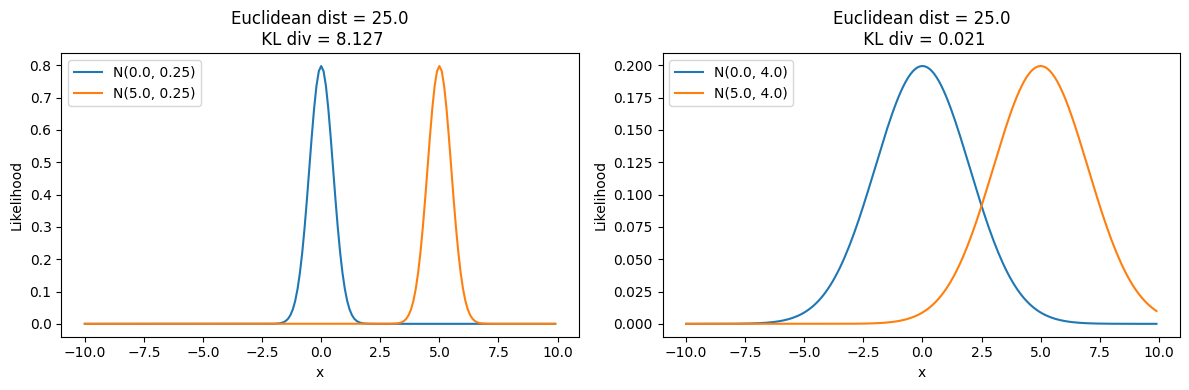

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
x_values = jnp.arange(-10, 10, 0.1)

mu_1 = 0.
mu_2 = 5.
std_1 = 0.5
y_values11 = stats.norm.pdf(x_values, mu_1, std_1)  # N(mu_1, std_1**2)
y_values12 = stats.norm.pdf(x_values, mu_2, std_1)  # N(mu_2, std_1**2)

std_2 = 2.0
y_values21 = stats.norm.pdf(x_values, mu_1, std_2)  # N(mu_1, std_2**2)
y_values22 = stats.norm.pdf(x_values, mu_2, std_2)  # N(mu_2, std_2**2)

# calc euclidean distances between distributions 1 and 2 in each scenario
param_11 = jnp.array([mu_1, std_1**2])
param_12 = jnp.array([mu_2, std_1**2])

param_21 = jnp.array([mu_1, std_2**2])
param_22 = jnp.array([mu_2, std_2**2])

e_dist_1 = jnp.sum((param_11 - param_12) ** 2)
e_dist_2 = jnp.sum((param_21 - param_22) ** 2)

print(f"Euclidean distance in setting 1: {e_dist_1} and setting 2: {e_dist_2}")

# let's code up KL divergence for scalar normals
def kl_normal(mu1, var1, mu2, var2):
  term1 = (mu1 - mu2) ** 2 / (2 * var2)
  term2 = 0.5 * (var1/var2 - 1 - jnp.log(var1) + jnp.log(var2))
  return term1 + term2

# whats the KL divergence between these two scenarios?
kl_div_1 = kl_normal(mu_1, mu_2, std_1 ** 2, std_1 ** 2)
kl_div_2 = kl_normal(mu_1, mu_2, std_1 ** 2, std_2 ** 2)
print(f"KL divergence in setting 1: {kl_div_1} and setting 2: {kl_div_2}")

# Create a figure and a 1x2 grid of subplots (for horizontal alignment)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot on the first subplot
sns.lineplot(x=x_values, y=y_values11, ax=axs[0], label=f"N({mu_1}, {std_1**2})")
sns.lineplot(x=x_values, y=y_values12, ax=axs[0], label=f"N({mu_2}, {std_1**2})")
axs[0].set_title(f"Euclidean dist = {e_dist_1}\n KL div = {kl_div_1:.3f}")
axs[0].set_xlabel('x')
axs[0].set_ylabel('Likelihood')

# Plot on the second subplot
sns.lineplot(x=x_values, y=y_values21, ax=axs[1], label=f"N({mu_1}, {std_2**2})")
sns.lineplot(x=x_values, y=y_values22, ax=axs[1], label=f"N({mu_2}, {std_2**2})")
axs[1].set_title(f"Euclidean dist = {e_dist_2}\n KL div = {kl_div_2:.3f}")
axs[1].set_xlabel('x')
axs[1].set_ylabel('Likelihood')

# Display the plot
plt.tight_layout()  # Adjust the layout to not overlap
plt.show()

In the above example, the Euclidean distance between the blue and orange distributions was the same, but the wider variance setting on the right "feels" like they should be more similar, given the larger overlap at relatively high density regions. This was reflected in the much lower KL divergence in the second scenario.

TBD: Add information on Fisher Information, how we approximate KL div, etc.

## Natural Gradient Descent
Recall under [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) we can iteratively optimize a function $f(\theta)$ by taking steps in the steepest direction,
$$ \theta_{t+1} = \theta_t - \rho_t \nabla f(\theta_t).$$
Interestingly, we can re-write this update as a *local* optimization problem,
$$ \theta_{t+1} = {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}||\theta - \theta_t||^2.$$
The intuition is that we'd like to find some $\theta$ which finds a direction that decreases $f$ at $\theta_t$, as rapidly as possible (i.e. $\nabla f(\theta_t)$ itself), while not moving too "far" away from $\theta_t$  where "far" is captured by a [*Euclidean distance*](https://en.wikipedia.org/wiki/Euclidean_distance) (i.e. $||\theta - \theta_t||^2$).

To see their equivalence we have,
$$\begin{align*}
& \frac{\partial}{\partial \theta} \left[\theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}||\theta - \theta_t||^2 \right] \\
 &= \frac{\partial}{\partial \theta} [\theta \cdot \nabla f(\theta_t)] + \frac{1}{2\rho_t}\frac{\partial}{\partial \theta} ||\theta - \theta_t||^2 \\
   &= \nabla f(\theta_t) - \frac{(\theta - \theta_t)}{\rho_t} ⇒ \\
   \theta_{t+1} &= \theta_t - \rho_t \nabla f(\theta_t).
\end{align*}$$

We saw [above](#statistical-divergences) how Euclidean distance can lead to less meaningful measures of distance when we care about parameters underlying statistical distributions. Can we improve inference if we used a notion of *statistical distance* or (surprise) *divergence* in the above formulation?

Let's replace $||\theta - \theta_t||^2$ with KL divergence,
$$\begin{align*}
\theta_{t+1} &= {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}D_{KL}(\theta||\theta_t) \\
  &\approx {\arg \min}_{\theta} \ \ \theta \cdot \nabla f(\theta_t) + \frac{1}{2\rho_t}(\theta - \theta_t)^T F(\theta_t)(\theta - \theta_t) ⇒ \\
\theta_{t+1} &= \theta_t - \rho_t F^{-1}(\theta_t)∇f(\theta_t) \\
  &= \theta_t - \rho_t \widetilde{\nabla} f(\theta_t).
\end{align*}$$

where $\widetilde{\nabla} f(\theta_t)$ is the *natural* gradient, defined as $ \widetilde{\nabla} f(\theta_t) := F^{-1}(\theta_t)∇f(\theta_t)$ and $F(\theta_t) = \mathbb{E}_{x \sim p(\theta_t)}\left[∇\log p(x | \theta_t)\nabla \log p(x | \theta_t)^T\right]$ is the [Fisher Information Matrix](https://en.wikipedia.org/wiki/Fisher_information).

To arrive at the approximation, we take the second-roder Taylor series of $D_{KL}$ TBD.

In [ ]:
# code for later